<a href="https://colab.research.google.com/github/tailornishant/Engg.-Drawing-Symbol-Detection/blob/main/CNN_Eng_Drawings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Symbols in Engineering Drawings
* Convolutional Neural Network for Multiclass
Imbalanced Dataset Classi
cation of Symbols in
Engineering Drawings
* EANN 2020

### Loading symbols files 

* Load necessary libraries 
* Read the file (pixels of symbols)

In [ ]:
%matplotlib inline 
import numpy as np # linear algebra
import pandas as pd #CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from random import randint
# imports for array-handling and plotting
import matplotlib
matplotlib.use('agg')
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from subprocess import check_output
%matplotlib inline
# hide warnings 
import warnings
warnings.filterwarnings('ignore')

# solve cudNN initialisation 
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Quick Exploratory Data Analysis (EDA)
* Show first few rows
* Column names 
* Shape (dimension of the dataframe)

In [ ]:
df =pd.read_csv('/content/drive/MyDrive/Dataset/Eng_Drawings_Symbol/Symbols_pixel.csv')

df.head()
df.columns
df.shape

(2431, 10001)

#### Generate headers names 
* This might not be necessary
* Just for clarity 


In [ ]:

# get the number df's columns
num_cols = df.shape[1]

# generate range of ints for suffixes
# with length exactly half that of num_cols;
# if num_cols is even, truncate concatenated list later
# to get to original list length
rng = range(1, (num_cols))

new_cols =  ['p_' + str(i) for i in rng]
new_cols.append('label')
# ensure the length of the new columns list is equal to the length of df's columns
df.columns = new_cols[:num_cols]
df.columns

Index(['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
       ...
       'p_9992', 'p_9993', 'p_9994', 'p_9995', 'p_9996', 'p_9997', 'p_9998',
       'p_9999', 'p_10000', 'label'],
      dtype='object', length=10001)

### Data and Labels 
* IF needed, Might want to separate labels from feature
* This resturns data into Panas Series 

In [ ]:
# extract labels (all rows, and last column)
n = df.shape[1] # number of columns 
labels =df['label']

features= df.iloc[:,0:n-1]
type(labels)

pandas.core.series.Series

In [ ]:
type(features)

pandas.core.frame.DataFrame

In [ ]:
features.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_9991,p_9992,p_9993,p_9994,p_9995,p_9996,p_9997,p_9998,p_9999,p_10000
0,255,255,255,255,255,255,255,255,255,255,...,255,255,0,0,0,0,0,0,0,0
1,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,255,255,255
2,255,255,255,255,255,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,255,255,255,...,255,255,255,255,255,255,255,255,255,255


#### Show some random symbols (EDA)

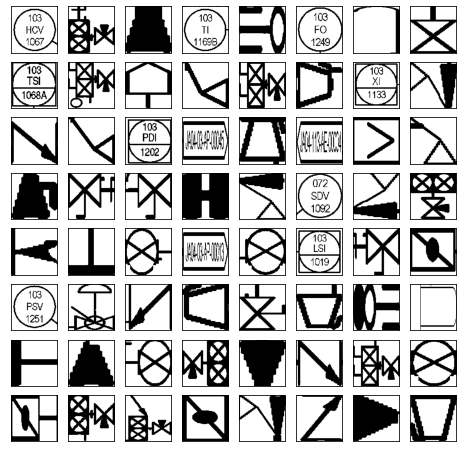

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
fx = features.values # returns numpy array

for i, axi in enumerate(ax.flat):
    value = randint(0, df.shape[0])
    axi.imshow(fx[value].reshape(100,100), cmap='gray')
    axi.set(xticks=[], yticks=[])

#### Class distribution 
* An extremly imbalanced problem 

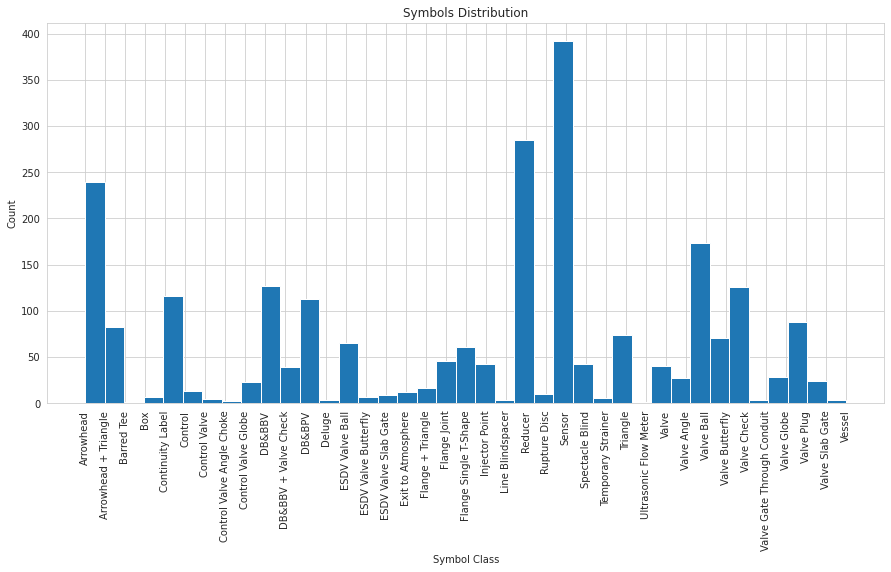

In [ ]:
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))

plt.hist(labels,bins=39)
plt.title('Symbols Distribution')
plt.xlabel('Symbol Class')
plt.ylabel('Count')

plt.xticks(rotation=90)
plt.show()

### Check and remove least frequent symbols 

* Some classes rarely appear
* and needs to be removed, 
* first check the numbers 

In [ ]:
## check class distribution 
df['label'].value_counts()


Sensor                        392
Reducer                       285
Arrowhead                     239
Valve Ball                    173
DB&BBV                        127
Valve Check                   126
Continuity Label              116
DB&BPV                        113
Valve Plug                     88
Arrowhead + Triangle           83
Triangle                       74
Valve Butterfly                71
ESDV Valve Ball                65
Flange Single T-Shape          61
Flange Joint                   46
Injector Point                 43
Spectacle Blind                42
Valve                          40
DB&BBV + Valve Check           39
Valve Globe                    28
Valve Angle                    27
Valve Slab Gate                24
Control Valve Globe            23
Flange + Triangle              17
Control                        13
Exit to Atmosphere             12
Rupture Disc                   10
ESDV Valve Slab Gate            9
ESDV Valve Butterfly            7
Box           

#### Remove symbols with less than 7 instances in the dataset

In [ ]:

df = df[~df['label'].isin(['Ultrasonic Flow Meter', 'Barred Tee','Temporary Strainer',
                     'Control Valve Angle Choke','Line Blindspacer',
                     'Vessel','Valve Gate Through Conduit','Deluge','Control Valve'])]

df['label'].value_counts()



Sensor                   392
Reducer                  285
Arrowhead                239
Valve Ball               173
DB&BBV                   127
Valve Check              126
Continuity Label         116
DB&BPV                   113
Valve Plug                88
Arrowhead + Triangle      83
Triangle                  74
Valve Butterfly           71
ESDV Valve Ball           65
Flange Single T-Shape     61
Flange Joint              46
Injector Point            43
Spectacle Blind           42
Valve                     40
DB&BBV + Valve Check      39
Valve Globe               28
Valve Angle               27
Valve Slab Gate           24
Control Valve Globe       23
Flange + Triangle         17
Control                   13
Exit to Atmosphere        12
Rupture Disc              10
ESDV Valve Slab Gate       9
ESDV Valve Butterfly       7
Box                        7
Name: label, dtype: int64

### Neural Networks (CNNs)

* Prepare the dataset
* check the shapes 

In [ ]:
# labels and features (separate data frames)
# retrieve numpy array (to meet keras requirements )
dataset = df.values
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

print(X.shape)
print(y.shape)


(2400, 10000)
(2400,)


In [ ]:
print(f'There are {len(df.label.unique())} Unique Symbol in the dataset') # check number of labels 


There are 30 Unique Symbol in the dataset


#### Prepare the data for the model
* Check the shapes of the input
* Split the data into train/ test subsets 
* Reshape the data 
* Prepare targets (labels)

In [ ]:
from sklearn.model_selection import train_test_split

# simple functions to check the shapes of all compoents of the dataset (train, test, labels)
def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
    
# split the data and check the shapes of results sets  
# train_test_split(...) returns numpy arrays 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
data_summary(X_train,y_train,X_test,y_test)

Train images shape: (1920, 10000)
Train labels shape: (1920,)
Test images shape: (480, 10000)
Test labels shape: (480,)


#### Prepare the data for the model
* Reshape the data
* Prepare targets (labels)
* Check shape of the arrays before and after 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils


print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 100,100,1)
X_test = X_test.reshape(X_test.shape[0], 100,100,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


print('___ AFTER RESHAPE________')
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)



X_train  (1920, 10000)
y_train  (1920,)
X-test  (480, 10000)
y_test  (480,)
___ AFTER RESHAPE________
X_train  (1920, 100, 100, 1)
y_train  (1920,)
X-test  (480, 100, 100, 1)
y_test  (480,)


#### Prepare the data for the model

* Prepare targets (labels)
* String labels have to be encoded first 

In [ ]:
# Encode target variables 
# prepare target
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train_cat = y_train
y_test_cat = y_test

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train,y_test)

print('y_train ',y_train.shape)
print('y_test ',y_test.shape)


y_train  (1920,)
y_test  (480,)


#### Encode Labes Data
* Notice how the shape of the arrays changes 

In [ ]:

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print('y_train ',y_train.shape)
print('y_test ',y_test.shape)


y_train  (1920, 30)
y_test  (480, 30)


### Validation Set

In [ ]:
# shuffle the training dataset (5 times!)

for _ in range(5): 
    indexes = np.random.permutation(len(X_train))

X_train = X_train[indexes]
y_train = y_train[indexes]

# Keep 10% of the training data for validation 
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(X_train))

# Validation set (val_data)
val_data = X_train[:val_count,:]
val_labels_cat = y_train[:val_count,:]




### Build Model 
* Train, validate and testing sets  

In [ ]:

def build_modelU():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(100, 100, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_modelU()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 128)       7

#### Results

In [ ]:
nEpochs = 25 
results = model.fit(X_train, y_train, 
                    epochs=nEpochs, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Epoch 1/25
30/30 [==============================] - 11s 49ms/step - loss: 6.2639 - accuracy: 0.1510 - val_loss: 2.5507 - val_accuracy: 0.3177
Epoch 2/25
30/30 [==============================] - 1s 42ms/step - loss: 2.3186 - accuracy: 0.3755 - val_loss: 1.5362 - val_accuracy: 0.5990
Epoch 3/25
30/30 [==============================] - 1s 42ms/step - loss: 1.5803 - accuracy: 0.5661 - val_loss: 0.8211 - val_accuracy: 0.8229
Epoch 4/25
30/30 [==============================] - 1s 41ms/step - loss: 1.1608 - accuracy: 0.6781 - val_loss: 0.5434 - val_accuracy: 0.8698
Epoch 5/25
30/30 [==============================] - 1s 41ms/step - loss: 0.9173 - accuracy: 0.7333 - val_loss: 0.4410 - val_accuracy: 0.9115
Epoch 6/25
30/30 [==============================] - 1s 41ms/step - loss: 0.7909 - accuracy: 0.7802 - val_loss: 0.3281 - val_accuracy: 0.9323
Epoch 7/25
30/30 [==============================] - 1s 42ms/step - loss: 0.6459 - accuracy: 0.8135 - val_loss: 0.2470 - val_accuracy: 0.9427
Epoch 8/25
3

#### Check results 

In [ ]:
history_dict = results.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# accuracy, test 
test_loss, test_accuracy = \
  model.evaluate(X_test, y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

8/8 [==============================] - 0s 39ms/step - loss: 0.1962 - accuracy: 0.9604
Test loss: 0.1962 accuracy: 0.9604


#### Make predictions

In [ ]:
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
print('Accuracy: ',sum(preds==actuals)/X_test.shape[0])


15/15 [==============================] - 0s 7ms/step
Accuracy:  0.9604166666666667


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_test,axis=1)).sum())

Test accuracy: 0.9604166746139526
15/15 [==============================] - 0s 9ms/step
Incorrectly Identified Symbols:  19


In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

predictions = model.predict(X_train)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_train,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_train,axis=1)).sum())

Train loss: 0.0065212310291826725
Train accuracy: 1.0
60/60 [==============================] - 0s 7ms/step
Incorrectly Identified Symbols:  0


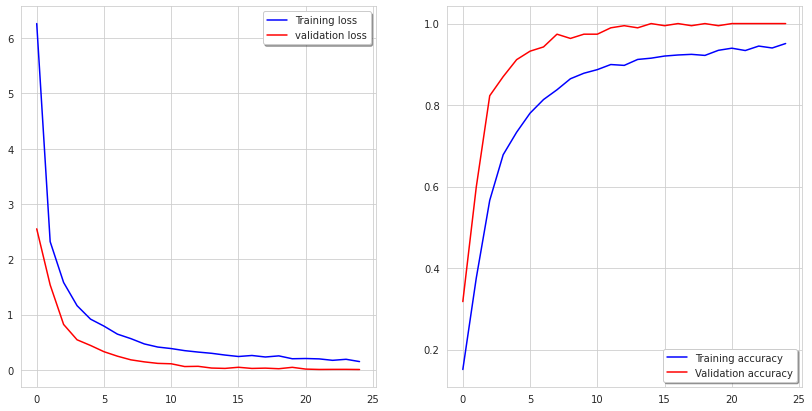

In [ ]:
# Plot the loss and accuracy curves for training and validation 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].plot(results.history['loss'], color='b', label="Training loss")
ax[0].plot(results.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Show some Predictions 

15/15 [==============================] - 0s 7ms/step


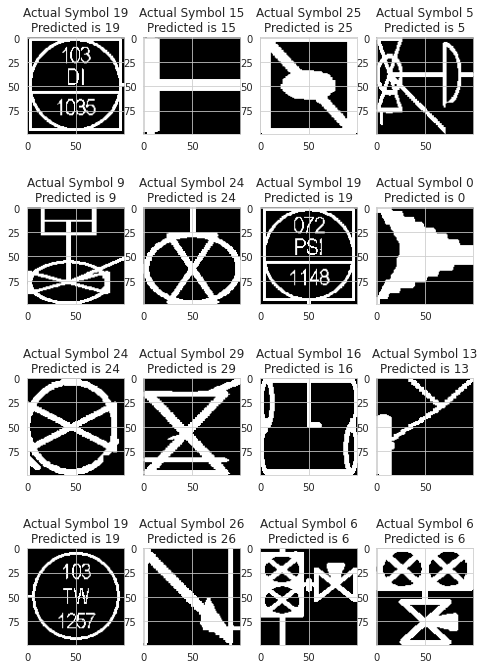

In [ ]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 100, 100)

fig, axis = plt.subplots(4, 4, figsize=(8, 12))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Actual Symbol {y_test[i].argmax()}\nPredicted is {y_pred[i].argmax()}");

In [ ]:
from keras.models import load_model
model.save('CNN_Eng_Drwg_Symbol.h5')

**Repository Credits:-** https://github.com/heyad/Eng_Diagrams